In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import h5py
import natsort

In [42]:
#name = 'Results/diffusion_squares_freq_2.5_5_10.hdf5'
#name = 'Results/diffusion_shepp_logan_freq_2.5_5_10.hdf5'
name = 'Results/diffusion_triangles_freq_2.5_5_10.hdf5'


# Loading truth eta
with h5py.File(f'{name}', 'r') as f:
    #print("Keys: %s" % f.keys())
    eta_re = f['eta'][()]

# Loading predicted eta
with h5py.File(f'{name}', 'r') as f:
    eta_re_pred = f['eta_pred'][()]

# Clean up temporary variables to free memory
#del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [43]:
eta_re.shape

(200, 80, 80, 1)

In [44]:
eta_re_pred.shape

(200, 4, 80, 80, 1)

In [45]:
cond_samples_metric = np.swapaxes(np.swapaxes(eta_re_pred[:,:,:,:,0],1,2),2,3)

In [46]:
cond_samples_metric.shape

(200, 80, 80, 4)

## RRMSE

### For deterministic

In [ ]:
MSE = np.zeros(cond_samples_metric.shape[0])
for i in range(cond_samples_metric.shape[0]):
    MSE[i] = np.linalg.norm(eta_re[i,:,:,0]-cond_samples_metric[i,:,:])/np.linalg.norm(eta_re[i,:,:,0])

### For probabilistic

In [47]:
MSE_ = np.zeros((cond_samples_metric.shape[0],cond_samples_metric.shape[-1]))
MSE = np.zeros(cond_samples_metric.shape[0])
for i in range(cond_samples_metric.shape[0]):
    for j in range(cond_samples_metric.shape[-1]):
        MSE_[i,j] = np.linalg.norm(eta_re[i,:,:,0]-cond_samples_metric[i,:,:,j])/np.linalg.norm(eta_re[i,:,:,0])
    MSE[i] = np.mean(MSE_[i,:])

In [48]:
print('Mean of validation relative l2 error:', np.mean(MSE))
print('Median of validation relative l2 error:', np.median(MSE))
print('Min of validation relative l2 error:', np.min(MSE))
print('Max of validation relative l2 error:', np.max(MSE))
print('Standard deviation of validation relative l2 errors:', np.std(MSE))

Mean of validation relative l2 error: 0.10270721798057003
Median of validation relative l2 error: 0.09288091811366013
Min of validation relative l2 error: 0.012519165667507864
Max of validation relative l2 error: 0.35075907207124757
Standard deviation of validation relative l2 errors: 0.08389802860356375


## CRPS

### For probabilistic

In [31]:
from swirl_dynamics.lib import metrics

In [49]:
crpss_1 = np.zeros((cond_samples_metric.shape[0],80,80))
for i in range(cond_samples_metric.shape[0]):
    crpss_1[i,:,:] = metrics.probabilistic_forecast.crps(cond_samples_metric[i,:,:,:], eta_re[i, :, :, 0], ensemble_axis=-1)

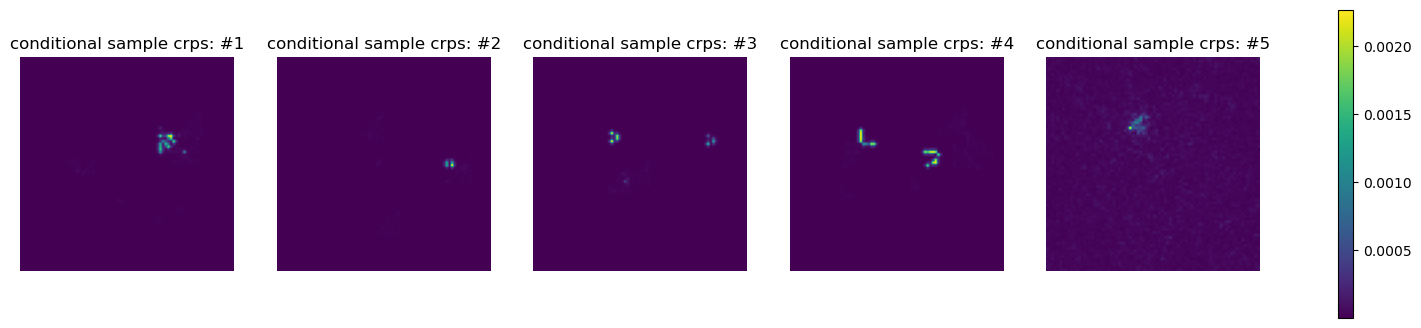

In [50]:
fig, axs = plt.subplots(1,5,figsize=(5*4, 4))
for i in range(5):
    im = axs[i].imshow(crpss_1[i, :, :])#, vmin=-2.5, vmax=2.5)
    axs[i].set_title(f"conditional sample crps: #{i + 1}")
    axs[i].axis("off")
fig.colorbar(im,ax=axs[:], location="right")
#plt.tight_layout()
plt.show()

In [51]:
# computing the \ell^1 metric
crpss_11 = np.zeros(cond_samples_metric.shape[0])
for i in range(cond_samples_metric.shape[0]):
    crpss_11[i] = np.sum(np.abs(crpss_1[i,:,:]))/(80*80)

In [52]:
print('CRPS = %.7f' % np.mean(crpss_11))

CRPS = 0.0002619


## Energy Spectrum

In [15]:
from pysteps.utils.spectral import rapsd

Pysteps configuration file found at: /home/mguerra4/miniconda3/envs/fwiinvscat/lib/python3.12/site-packages/pysteps/pystepsrc



### For deterministic

In [ ]:
rapsds_ref = np.zeros((eta_re.shape[0], 40))
rapsds = np.zeros((eta_re.shape[0],40))
rapsds_error_ = np.zeros(eta_re.shape[0])
for i in range(eta_re.shape[0]):
    rapsds_ref[i,:] = rapsd(eta_re[i,:,:,:],fft_method=np.fft)
    rapsds[i,:] = rapsd(eta_re_pred[i,:,:],fft_method=np.fft)

In [ ]:
rapsds_error_ = np.abs(np.log(np.mean(rapsds,axis=0)/np.mean(rapsds_ref,axis=0)))

In [ ]:
print('radially averaged power spectrum = %.5f' % np.mean(rapsds_error_))

### For probabilistic

In [53]:
rapsds = np.zeros((cond_samples_metric.shape[0], cond_samples_metric.shape[-1], 40))
rapsds_ref = np.zeros((cond_samples_metric.shape[0], 40))
rapsds_mean = np.zeros((cond_samples_metric.shape[0],40))
for i in range(cond_samples_metric.shape[0]):
    rapsds_ref[i,:] = rapsd(eta_re[i,:,:,0],fft_method=np.fft)
    for j in range(cond_samples_metric.shape[-1]):
        rapsds[i,j,:] = rapsd(cond_samples_metric[i,:,:,j],fft_method=np.fft)
    rapsds_mean[i,:] = np.mean(rapsds[i,:,:],axis=0)

In [54]:
rapsds_mean.shape

(200, 40)

In [55]:
rapsds_ref.shape

(200, 40)

In [56]:
rapsds_error_ = np.mean(np.abs(np.log(rapsds_mean) - np.log(rapsds_ref)),axis=1)

In [57]:
rapsds_error_.shape

(200,)

In [58]:
print('radially averaged power spectrum = %.5f' % np.mean(rapsds_error_))

radially averaged power spectrum = 0.04442


## Sinkhorn

In [22]:
import ott
from ott import problems
from ott.geometry import costs, pointcloud
from ott.solvers import linear
from ott.problems.linear import linear_problem
from ott.solvers.linear import acceleration, sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

from scipy.ndimage import gaussian_filter

### For deterministic

In [ ]:
eta_re_vect = eta_re[:,:,:].reshape((eta_re.shape[0],80*80))
eta_re_pred_vect = eta_re_pred[:,:,:].reshape((eta_re_pred.shape[0],80*80))

In [ ]:
geom = pointcloud.PointCloud(eta_re_vect[0,:], eta_re_pred_vect[0,:], cost_fn=costs.Euclidean())

In [ ]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)
# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

### For probabilistic

In [ ]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Number of training datapoints.
NTRAIN = 18000

In [ ]:
#name = 'Data/traindata_smooth_sigma_0.04'
#name = 'Data/traindata_shepp_logan'
name = 'Data/traindata_L4s5_multifreq_ns10_square_10h_freq_2.5_5_10'
#name = 'Data/traindata_3510tri'


# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re_train = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re_train = np.stack([blur_fn(eta_re_train[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Clean up temporary variables to free memory
#del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [ ]:
eta_re_train.shape

In [ ]:
num_samples_metric = 100

In [ ]:
eta_re_pred.shape

In [ ]:
samples_theta = np.zeros((num_samples_metric*eta_re_pred.shape[1],80*80))
samples_test = np.zeros((num_samples_metric*eta_re_pred.shape[1],80*80))
samples_training = np.zeros((NTRAIN,80*80))
samples_theta[:,:] = eta_re_pred[:num_samples_metric,:,:,:,0].reshape((num_samples_metric*eta_re_pred.shape[1],80*80))
samples_test[:,:] = eta_re[:num_samples_metric*eta_re_pred.shape[1],:,:,0].reshape(num_samples_metric*eta_re_pred.shape[1],80*80)
samples_training[:,:] = eta_re_train[:,:,:].reshape(NTRAIN,80*80)

In [ ]:
#ot_ref = []
ot_test = []
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
for i in range(1,num_samples_metric*eta_re_pred.shape[1]+1):
    #geom_1 = pointcloud.PointCloud(samples_training[:i,:], samples_test[:i,:], cost_fn=costs.Euclidean())
    geom_2 = pointcloud.PointCloud(samples_theta[:i,:], samples_test[:i,:], cost_fn=costs.Euclidean())
    # Define a linear problem with that cost structure.
    #ot_prob_ref = linear_problem.LinearProblem(geom_1)
    ot_prob_test = linear_problem.LinearProblem(geom_2)
    # Solve OT problem
    #ot_1 = solver(ot_prob_ref)
    ot_2 = solver(ot_prob_test)
    #ot_ref.append(ot_1.reg_ot_cost)
    ot_test.append(ot_2.reg_ot_cost)

In [ ]:
len(ot_test)

In [ ]:
plt.plot(range(1,len(ot_test)+1), abs(np.array(ot_test) - np.array(ot_ref)))
#plt.yscale('log')
plt.ylabel('OT cost')
plt.xlabel('samples')
#plt.savefig('sinkhorn_smooth_sigma_0.04_comparison_abs.png')
plt.show()

In [ ]:
#plt.plot(range(1,len(ot_test)+1), np.array(ot_ref), label="SD ref")
plt.plot(range(1,len(ot_test)+1), np.array(ot_test), label="SD gen")
#plt.yscale('log')
plt.ylabel('OT cost')
plt.xlabel('samples')
plt.legend()
#plt.savefig('sinkhorn_smooth_sigma_0.04.png')
plt.show()

In [ ]:
print('Sinkhorn divergence ref = %.5f' % ot_ref[len(ot_test)-1])

In [ ]:
print('Sinkhorn divergence test = %.5f' % ot_test[len(ot_test)-1])

In [ ]:
print('|ref-test| = %.5f' % abs(ot_ref[len(ot_test)-1] - ot_test[len(ot_test)-1]))